# Deep Q Learning & Double Q learning with Taxi-v3 example in Gym


# 1. Imports

In [2]:
import numpy as np
import random
import gym
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from tensorflow.keras.layers import Dense, Flatten, Embedding
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy,LinearAnnealedPolicy,BoltzmannQPolicy
from rl.core import Processor
import json
import matplotlib.pyplot as plt

# 2. A function for creating the agent

In [3]:
def create_agent(states, actions): #WITHOUT EMBEDDINGS - Code labelled as such is retained to be reusable for further experimentation 
    model = Sequential()
    model.add(Flatten(input_shape=(1, states)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model
def create_agent_with_embedding(states, actions): #WITH EMBEDDINGS
    model = Sequential()
    model.add(Embedding(input_dim=states, output_dim=10, input_length=1))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model


# 3. Defining the connection between  the environment and agent

In [4]:
#class TaxiProcessor(Processor): #WITHOUT EMBEDDINGS
    #def __init__(self, states):
       # self.states = states 
        
class TaxiProcessor(Processor): #WITH EMBEDDINGS
    def process_observation(self, observation):
        return observation  

    #def process_observation(self, observation): #WITHOUT EMBEDDINGS
        #one_hot = np.zeros(self.states)
        #one_hot[observation] = 1
        #return one_hot
    
#deterministic rewards
#    def process_reward(self, r): 
#        if r == 20:      # successful dropoff
 #           return +20   
#        elif r == -1:    
#            return -0.1  # Smallre penalty
#        elif r == -10:   
 #           return -2.0  # Stronger penalty
 #       return r
    
    #slippery rewards 
    def process_reward(self, r):
        noise = np.random.normal(0, 0.01)  #small standard deviation
        if r == 20:  
            return 20 + noise 
        elif r == -1:  
            return -0.1 + noise  # Small penalty with noise
        elif r == -10:  
            return -2.0 + noise
        return r


# 4. Create the environment and DQNAgent

In [7]:
env = gym.make('Taxi-v3')
states= env.observation_space.n
actions= env.action_space.n
print("No of state = ", env.observation_space.n)
print("No of actions =", env.action_space.n)
#model = create_agent(states=env.observation_space.n, actions=env.action_space.n) #WITHOUT EMBEDDINGS
model_standard = create_agent_with_embedding(states, actions) #WITH EMBEDDINGS
model_double = create_agent_with_embedding(states, actions) #WITH EMBEDDINGS

model_standard.summary()
model_double.summary()

No of state =  500
No of actions = 6
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 10)             5000      
                                                                 
 flatten_2 (Flatten)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                                 
Total params: 6,606
Trainable params: 6,606
Non-trainable params: 0
_________________________________________________________________
Model: "sequent

In [29]:
#processor = TaxiProcessor(states) #WITHOUT EMBEDDINGS

processor = TaxiProcessor() #WITH EMBEDDINGS

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',value_max=1., value_min=0.1, value_test=0.05, nb_steps=12000) # cahnge nb_steps to 12k/20k

#policy = BoltzmannQPolicy() 
#policy = EpsGreedyQPolicy()

standard_memory = SequentialMemory(limit=50000, window_length=1)
double_memory = SequentialMemory(limit=50000, window_length=1)
standard_dqn = DQNAgent(model=model_standard, nb_actions=actions, processor = processor,
               memory=standard_memory, nb_steps_warmup=200, gamma=0.95, policy=policy,
              enable_double_dqn= False,target_model_update= 1e-2)
double_dqn = DQNAgent(model=model_double, nb_actions=actions, processor = processor,
               memory=double_memory, nb_steps_warmup=200, gamma=0.95, policy=policy,
              enable_double_dqn= True,target_model_update= 1e-2)

# 5. Compile and train

In [30]:
#DOUBLE Q LEARNING TRAINING
#Training WITH EMBEDDINGS- uncomment lines followed by #WITH EMBEDDINGS

double_dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
print("-------------------Training  DOUBLE DQN Agent-----------------------")
double_history = double_dqn.fit(env, nb_steps=20000, nb_max_episode_steps=100, visualize=False, verbose=1, log_interval=4000)

# Saving model weights and training history
weights_file = 'double_dqn_weights.h5f'
double_dqn.save_weights(weights_file, overwrite=True)

serializable_history_DOUBLE = {
    key: [int(x) if isinstance(x, (np.integer, np.int32, np.int64)) else float(x) for x in val]
    for key, val in double_history.history.items()}
with open('double_dqn_trainingHistory.json', 'w') as f:
    json.dump(serializable_history_DOUBLE, f)

-------------------Training  DOUBLE DQN Agent-----------------------
Training for 20000 steps ...
Interval 1 (0 steps performed)
4000/4000 [==============================] - 57s 14ms/step - reward: 1.3344
290 episodes - episode_reward: 18.411 [14.436, 19.495] - loss: 0.002 - mae: 10.479 - mean_q: 14.274 - mean_eps: 0.050 - prob: 1.000

Interval 2 (4000 steps performed)
4000/4000 [==============================] - 60s 15ms/step - reward: 1.2820
280 episodes - episode_reward: 18.308 [14.014, 19.523] - loss: 0.001 - mae: 10.460 - mean_q: 14.224 - mean_eps: 0.050 - prob: 1.000

Interval 3 (8000 steps performed)
4000/4000 [==============================] - 60s 15ms/step - reward: 1.2948
283 episodes - episode_reward: 18.301 [10.508, 19.492] - loss: 0.001 - mae: 10.415 - mean_q: 14.167 - mean_eps: 0.050 - prob: 1.000

Interval 4 (12000 steps performed)
4000/4000 [==============================] - 61s 15ms/step - reward: 1.2829
279 episodes - episode_reward: 18.396 [12.766, 19.476] - loss: 0.

In [36]:
# DEEP Q LEARNING TRAINING
#Training WITH EMBEDDINGS- uncomment lines followed by #WITH EMBEDDINGS
standard_dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
print("---------------------Training  DQN Agent-----------------------")

standard_history = standard_dqn.fit(env, nb_steps=20000, nb_max_episode_steps=100, visualize=False, verbose=1, log_interval=4000)

# Saving model weights and training history
weights_file = 'standard_dqn_weights.h5f'
standard_dqn.save_weights(weights_file, overwrite=True)

serializable_history = {
    key: [int(x) if isinstance(x, (np.integer, np.int32, np.int64)) else float(x) for x in val]
    for key, val in standard_history.history.items()}
with open('standard_dqn_trainingHistory.json', 'w') as f:
    json.dump(serializable_history, f)

---------------------Training  DQN Agent-----------------------
Training for 20000 steps ...
Interval 1 (0 steps performed)
4000/4000 [==============================] - 66s 16ms/step - reward: -0.5356
46 episodes - episode_reward: -46.206 [-83.960, 5.818] - loss: 0.232 - mae: 5.487 - mean_q: 7.207 - mean_eps: 0.843 - prob: 1.000

Interval 2 (4000 steps performed)
4000/4000 [==============================] - 65s 16ms/step - reward: -0.0884
85 episodes - episode_reward: -4.351 [-59.448, 17.219] - loss: 0.253 - mae: 5.773 - mean_q: 7.489 - mean_eps: 0.550 - prob: 1.000

Interval 3 (8000 steps performed)
4000/4000 [==============================] - 66s 17ms/step - reward: 0.5607
167 episodes - episode_reward: 13.529 [-36.582, 19.220] - loss: 0.281 - mae: 6.361 - mean_q: 8.641 - mean_eps: 0.250 - prob: 1.000

Interval 4 (12000 steps performed)
4000/4000 [==============================] - 69s 17ms/step - reward: 0.8948
214 episodes - episode_reward: 16.706 [-17.706, 19.474] - loss: 0.388 - m

In [37]:
# Training without embeddings - uncomment lines followed by #WITHOUT EMBEDDINGS
 
#dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

#history = dqn.fit(env, nb_steps=5000, nb_max_episode_steps=100, visualize=False, verbose=1, log_interval=5000)

# Saving model weights and training history
#weights_file = 'taxiWeights.h5f'
#dqn.save_weights(weights_file, overwrite=True)

#serializable_history = {
#    key: [int(x) if isinstance(x, (np.integer, np.int32, np.int64)) else float(x) for x in val]
#    for key, val in history.history.items()}
#with open('trainingHistory.json', 'w') as f:
#    json.dump(serializable_history, f)

# 6. Test both agents

In [38]:
# === TEST BOTH AGENTS ===
def test_agent(agent, weights_file, label):
    agent.load_weights(weights_file)
    env.reset()
    res = agent.test(env, nb_episodes=10, nb_max_episode_steps=100, visualize=False, verbose=0)
    test_rewards = res.history['episode_reward']
    print(f"\n// Test Performance Summary: {label}")
    print(f"Total Test Episodes: {len(test_rewards)}")
    print(f"Average Reward      : {np.mean(test_rewards):.2f}")
    print(f"Standard Deviation  : {np.std(test_rewards):.2f}")
    print(f"Min Reward          : {np.min(test_rewards)}")
    print(f"Max Reward          : {np.max(test_rewards)}")
    return test_rewards
double_rewards = test_agent(double_dqn, 'double_dqn_weights.h5f', "Double DQN")
standard_rewards = test_agent(standard_dqn, 'standard_dqn_weights.h5f', "Standard DQN")


// Test Performance Summary: Double DQN
Total Test Episodes: 10
Average Reward      : 18.66
Standard Deviation  : 0.17
Min Reward          : 18.419016925328716
Max Reward          : 19.00782522049223

// Test Performance Summary: Standard DQN
Total Test Episodes: 10
Average Reward      : 18.63
Standard Deviation  : 0.28
Min Reward          : 18.37958182694708
Max Reward          : 19.290292170523013


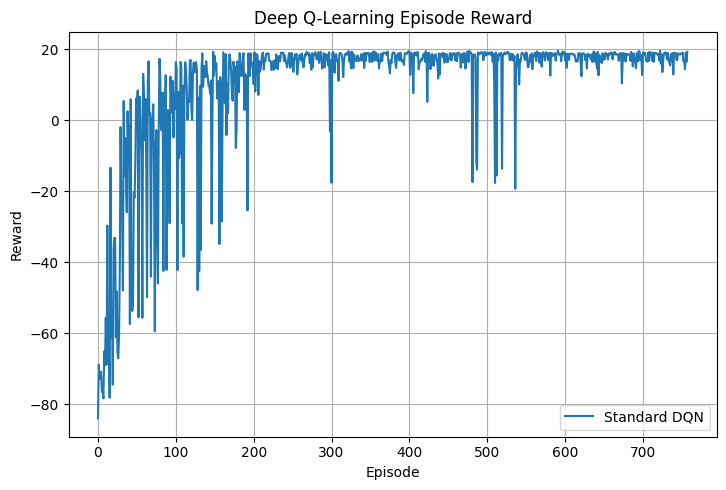

In [40]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(standard_history.history['episode_reward'], label='Standard DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Deep Q-Learning Episode Reward')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

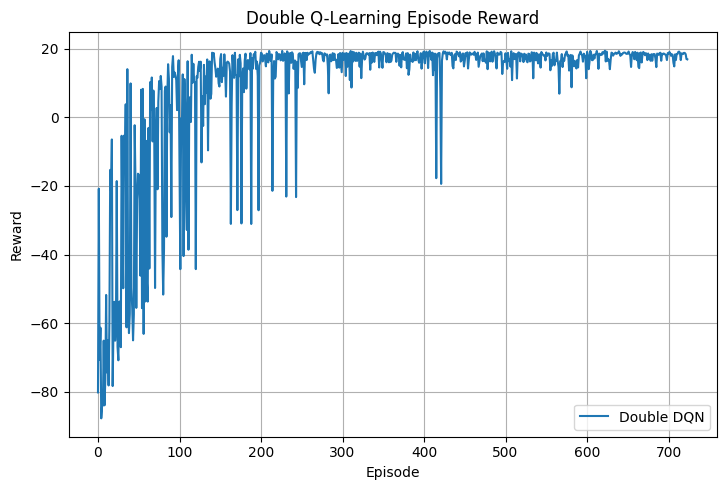

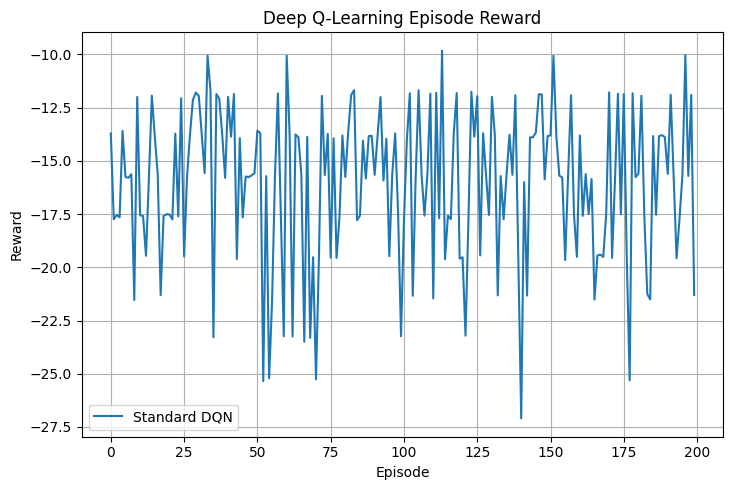

In [21]:
plt.figure(figsize=(14, 5))
# Episode Reward
plt.subplot(1, 2, 1)
plt.plot(double_history.history['episode_reward'], label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Double Q-Learning Episode Reward')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()